# Notebook 02: Pair Selection and Correlation Analysis

In [3]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

#### 1. Load Data

In [7]:
df = pd.read_csv("../data/processed/spy_ivv_daily.csv", index_col=0, parse_dates=True)
print(f"Loaded {len(df)} days of data")
df.head()

Loaded 3028 days of data


,IVV,SPY,log_IVV,ret_IVV,log_SPY,ret_SPY
Date,,,,,,
2014-01-03,149.364105,148.961609,5.006387,-0.000435,5.003689,-0.000164
2014-01-06,148.958069,148.529892,5.003665,-0.002722,5.000786,-0.002902
2014-01-07,149.875717,149.442169,5.009806,0.006142,5.006909,0.006123
2014-01-08,149.956970,149.474762,5.010348,0.000542,5.007128,0.000218
2014-01-09,150.030029,149.572495,5.010835,0.000487,5.007781,0.000654


#### 2. Why SPY-IVV?
# 
#### Economic Rationale
#### - **Index:** Both track the S&P 500 (identical benchmark)
#### - **Holdings:** Nearly identical portfolios (same 500 stocks, similar weights)
#### - **Liquidity:** Both are among the most liquid ETFs globally
#### - **Arbitrage:** Any price divergence violates law of one price → should revert
# 
#### Statistical Rationale
#### - Near-perfect return correlation (>0.99)
#### - Should be cointegrated by construction
#### - Classic textbook example of pairs trading

#### 3. Correlation Analysis

In [15]:
# Static correlation (full sample)
corr_matrix = df[["ret_SPY", "ret_IVV"]].corr()
print("Full Sample Return Correlation:")
print(corr_matrix)
print(f"\nCorrelation: {corr_matrix.iloc[0, 1]:.6f}")
print("Expected: >0.99 for same-index ETFs")

Full Sample Return Correlation:
          ret_SPY   ret_IVV
ret_SPY  1.000000  0.998949
ret_IVV  0.998949  1.000000

Correlation: 0.998949
Expected: >0.99 for same-index ETFs


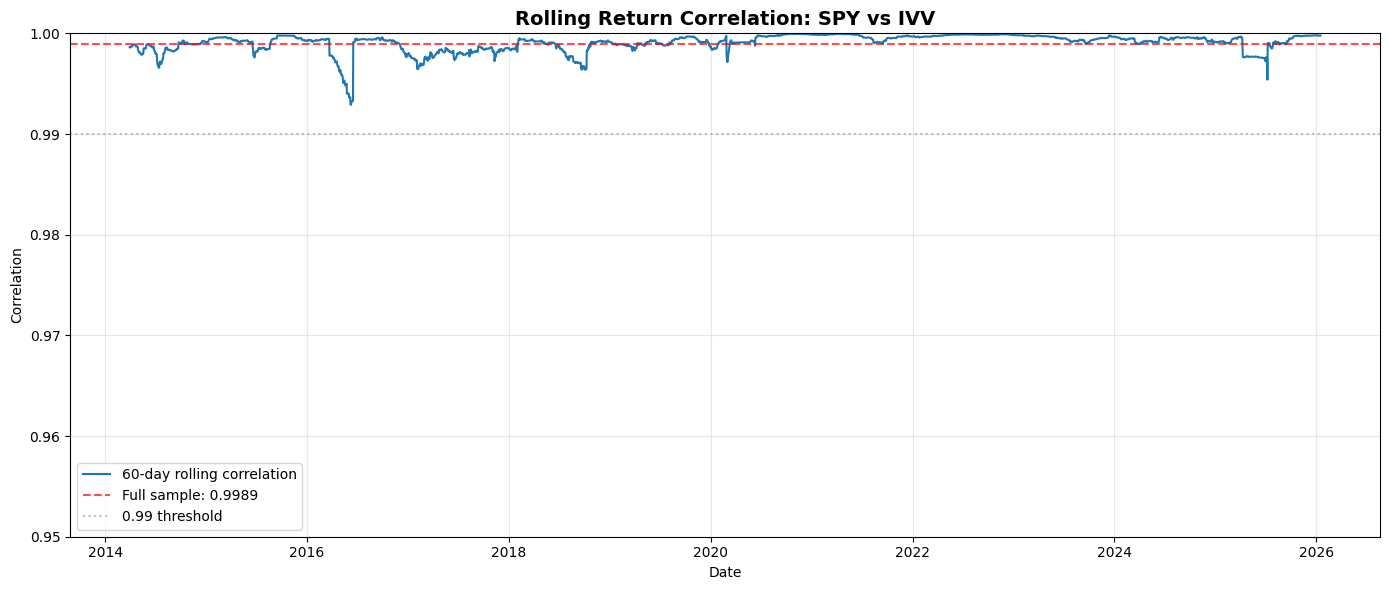


Correlation statistics:
Mean: 0.999072
Std: 0.000880
Min: 0.992908
Max: 0.999951


In [17]:
# Rolling correlation (60-day window)
window = 60
rolling_corr = df["ret_SPY"].rolling(window).corr(df["ret_IVV"])

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(rolling_corr.index, rolling_corr, linewidth=1.5, label=f"{window}-day rolling correlation")
ax.axhline(corr_matrix.iloc[0, 1], color='red', linestyle='--', 
           label=f"Full sample: {corr_matrix.iloc[0, 1]:.4f}", alpha=0.7)
ax.axhline(0.99, color='gray', linestyle=':', alpha=0.5, label="0.99 threshold")
ax.set_title("Rolling Return Correlation: SPY vs IVV", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Correlation")
ax.set_ylim([0.95, 1.0])  # Zoom in on high correlation range
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../reports/figures/02_rolling_correlation.png", dpi=150)
plt.show()

print(f"\nCorrelation statistics:")
print(f"Mean: {rolling_corr.mean():.6f}")
print(f"Std: {rolling_corr.std():.6f}")
print(f"Min: {rolling_corr.min():.6f}")
print(f"Max: {rolling_corr.max():.6f}")

#### 4. Price Ratio Analysis
#### Since both ETFs track the same index, their price ratio should be extremely stable.

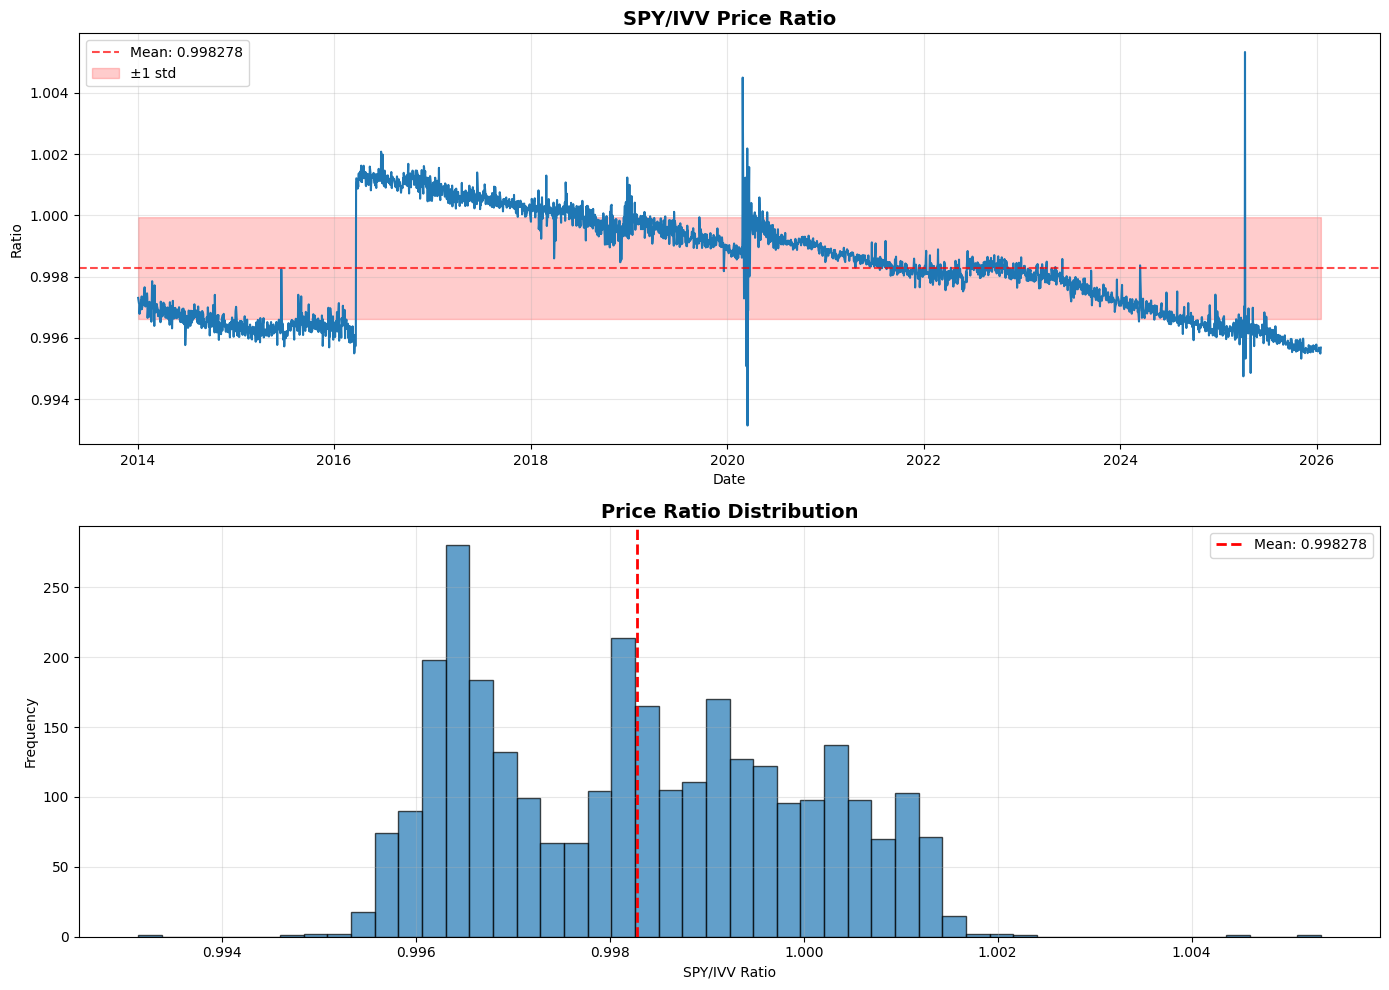


Price ratio statistics:
  Mean: 0.998278
  Std: 0.001662 (very low = stable)
  Coefficient of Variation: 0.001665


In [21]:
# Simple price ratio
df["price_ratio"] = df["SPY"] / df["IVV"]

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Price ratio over time
axes[0].plot(df.index, df["price_ratio"], linewidth=1.5)
axes[0].axhline(df["price_ratio"].mean(), color='red', linestyle='--', 
                label=f"Mean: {df['price_ratio'].mean():.6f}", alpha=0.7)
# Add +/- 1 std bands
axes[0].fill_between(df.index, 
                     df["price_ratio"].mean() - df["price_ratio"].std(),
                     df["price_ratio"].mean() + df["price_ratio"].std(),
                     alpha=0.2, color='red', label='±1 std')
axes[0].set_title("SPY/IVV Price Ratio", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Ratio")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Distribution
axes[1].hist(df["price_ratio"], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(df["price_ratio"].mean(), color='red', linestyle='--', 
                label=f"Mean: {df['price_ratio'].mean():.6f}", linewidth=2)
axes[1].set_title("Price Ratio Distribution", fontsize=14, fontweight='bold')
axes[1].set_xlabel("SPY/IVV Ratio")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../reports/figures/02_price_ratio.png", dpi=150)
plt.show()

print(f"\nPrice ratio statistics:")
print(f"  Mean: {df['price_ratio'].mean():.6f}")
print(f"  Std: {df['price_ratio'].std():.6f} (very low = stable)")
print(f"  Coefficient of Variation: {df['price_ratio'].std() / df['price_ratio'].mean():.6f}")

#### 5. Volatility Comparison

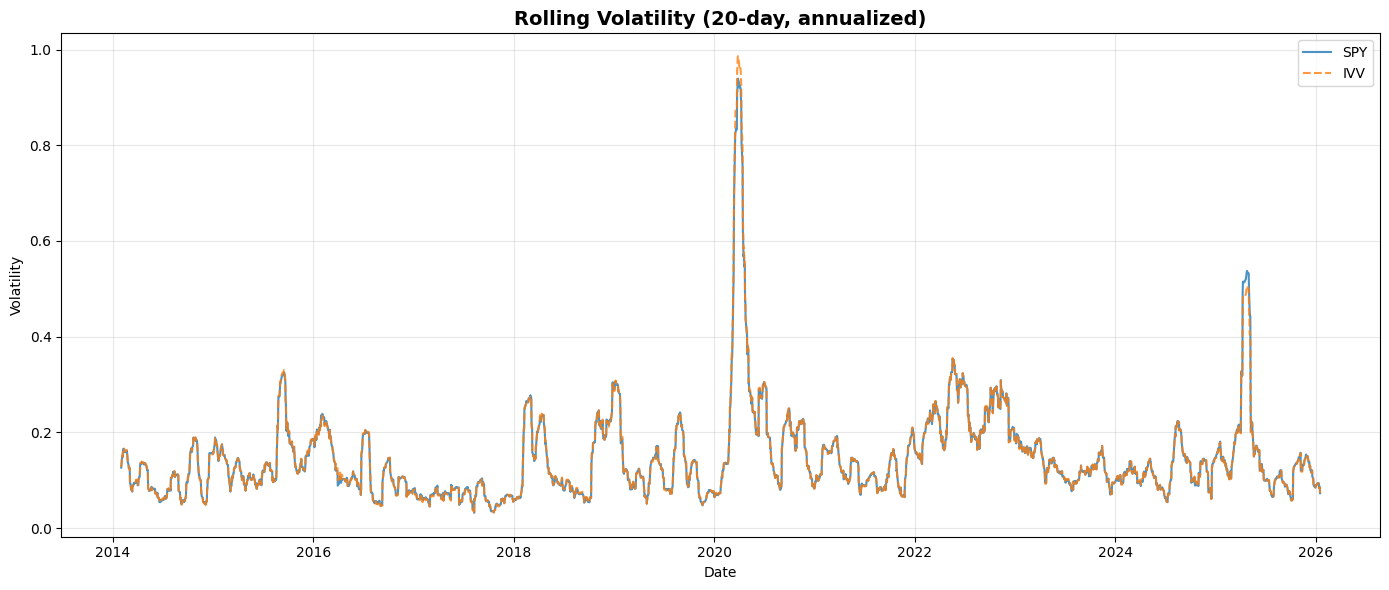


Average annualized volatility:
SPY: 14.55%
IVV: 14.57%
Difference: 0.0174% (should be minimal)


In [24]:
# Rolling volatility (20-day)
vol_window = 20
df["vol_SPY"] = df["ret_SPY"].rolling(vol_window).std() * np.sqrt(252)
df["vol_IVV"] = df["ret_IVV"].rolling(vol_window).std() * np.sqrt(252)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df["vol_SPY"], label="SPY", linewidth=1.5, alpha=0.8)
ax.plot(df.index, df["vol_IVV"], label="IVV", linewidth=1.5, alpha=0.8, linestyle='--')
ax.set_title(f"Rolling Volatility ({vol_window}-day, annualized)", fontsize=14, fontweight='bold')
ax.set_xlabel("Date")
ax.set_ylabel("Volatility")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../reports/figures/02_volatility.png", dpi=150)
plt.show()

print("\nAverage annualized volatility:")
print(f"SPY: {df['vol_SPY'].mean():.2%}")
print(f"IVV: {df['vol_IVV'].mean():.2%}")
print(f"Difference: {abs(df['vol_SPY'].mean() - df['vol_IVV'].mean()):.4%} (should be minimal)")

#### 6. Summary
# 
#### Correlation Analysis
#### - Return correlation is **consistently >0.99** (near-perfect)
#### - Correlation is **extremely stable** over time
#### - This is expected since both track the same index
# 
#### Economic Link
#### - SPY and IVV hold the same assets (S&P 500 constituents)
#### - Any price divergence is an arbitrage opportunity
#### - Law of one price guarantees mean reversion
# 
#### Comparison to KO-PEP
#### - SPY-IVV shows much stronger statistical relationship
#### - Price ratio has minimal drift (coefficient of variation <0.01)
#### - This pair should easily pass cointegration test
# 
#### Next Step
#### - **Formal cointegration test** using Engle-Granger (Notebook 03)
#### - Expected: p-value < 0.001, beta ≈ 1.0, stable rolling beta